In [1]:
import pandas as pd


train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')
print(len(train_data))
train_data.head()

# train_data.drop_duplicates(subset=['document'], inplace=True)
# train_data = train_data.dropna(how = 'any')


150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import re

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    
    word_to_index = {word:index for index, word in enumerate(vocab)}


#     index_to_word2 = {index:word for word, index in word_to_index.items()}
#     # print(index_to_word)

#     index_to_word=dict()
#     for idx in index_to_word:

#         regex = re.compile('[^가-힣+]')
#         result = regex.sub('',index_to_word[idx])
#     #     print(result)
#     #     print(idx)
#         if not result=='':
#             index_to_word2[idx] = result

#     word_to_index2 = {index:word for word, index in index_to_word2.items()}

#     word_to_index2
    
    
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}


# 전처리를 하다 보니 빈값과 특수문자가 많아서 다 없애려는 시도를 해봤는데 코드에 적용하려니 잘 되지 않는다 시도 해봤다는것에 만족하자

In [4]:


# index_to_word = {index:word for word, index in word_to_index.items()}
# # print(index_to_word)

# index_to_word2=dict()
# for idx in index_to_word:
   
#     regex = re.compile('[^가-힣+]')
#     result = regex.sub('',index_to_word[idx])
# #     print(result)
# #     print(idx)
#     if not result=='':
#         index_to_word2[idx] = result
       
# word_to_index2 = {index:word for word, index in index_to_word2.items()}

# word_to_index2

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
   

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
 
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[0]

'<PAD>'

In [8]:
import tensorflow as tf
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.reshape)
print(x_test.shape)

<built-in method reshape of numpy.ndarray object at 0x7f393bc2d810>
(49157, 41)


In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 어떻게 데이터를 분리 해야될까? 
49157
25000를 1만개 1만 5천개 정도로 나눴으니까
2만 3만으 정도로 나눠보자

In [10]:

x_val = x_train[:20000]   
y_val = y_train[:20000]


partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]
print(x_train.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(146182, 41)
(126182, 41)
(126182,)


# 모델 훈련 개시

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 20s 7ms/step - loss: 0.5748 - accuracy: 0.6803 - val_loss: 0.4028 - val_accuracy: 0.8346
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3587 - accuracy: 0.8506 - val_loss: 0.3487 - val_accuracy: 0.8475
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3240 - accuracy: 0.8646 - val_loss: 0.3484 - val_accuracy: 0.8465
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3109 - accuracy: 0.8700 - val_loss: 0.3515 - val_accuracy: 0.8498
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3031 - accuracy: 0.8739 - val_loss: 0.3484 - val_accuracy: 0.8508
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8761 - val_loss: 0.3523 - val_accuracy: 0.8496
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8781 - val_loss: 0.3522 - val_accuracy: 0.8497
Epoch

In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4001 - accuracy: 0.8338
[0.40009188652038574, 0.833797812461853]


# 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


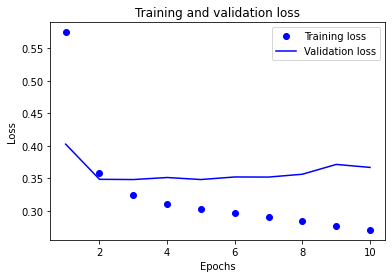

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
from gensim.models import KeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'

word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)



In [16]:
word2vec.similar_by_word("good")

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348937988281),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728254318237),
 ('solid', 0.5806034803390503),
 ('lousy', 0.5764201879501343)]

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    try:
        if index_to_word[i] in word2vec:
            embedding_matrix[i] = word2vec[index_to_word[i]]
    except KeyError:
        index_to_word[i] =''
  

In [18]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [19]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 10s 10ms/step - loss: 0.6246 - accuracy: 0.6343 - val_loss: 0.4702 - val_accuracy: 0.7793
Epoch 2/20
247/247 [==============================] - 2s 8ms/step - loss: 0.4239 - accuracy: 0.8078 - val_loss: 0.4255 - val_accuracy: 0.8076
Epoch 3/20
247/247 [==============================] - 2s 8ms/step - loss: 0.3694 - accuracy: 0.8396 - val_loss: 0.4093 - val_accuracy: 0.8164
Epoch 4/20
247/247 [==============================] - 2s 8ms/step - loss: 0.3432 - accuracy: 0.8538 - val_loss: 0.3965 - val_accuracy: 0.8253
Epoch 5/20
247/247 [==============================] - 2s 8ms/step - loss: 0.3192 - accuracy: 0.8659 - val_loss: 0.3835 - val_accuracy: 0.8343
Epoch 6/20
247/247 [==============================] - 2s 8ms/step - loss: 0.3001 - accuracy: 0.8757 - val_loss: 0.3864 - val_accuracy: 0.8332
Epoch 7/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2923 - accuracy: 0.8803 - val_loss: 0.4255 - val_accuracy: 0.8198
Epoc

In [20]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.9730 - accuracy: 0.5607
[1.9730390310287476, 0.56073397397995]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


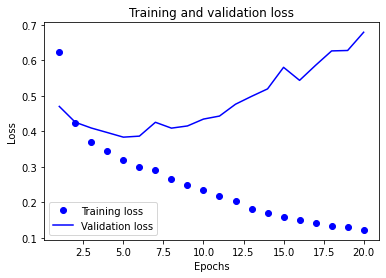

In [21]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from gensim.models import Word2Vec

# word2vec = gensim.models.Word2Vec.load(word2vec_path)
model = Word2Vec(sentences = X_train, window = 5, min_count = 5, workers = 4, sg = 0)


In [ ]:
model.wv.vectors.shape

 9997개 100차원 구성 이렇게 하는게 아닌가...


# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [28]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec.wv.most_similar('사랑')
vector = word2vec['사랑']
len(vector)

/tmp/ipykernel_3488/252046743.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


200

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    try:
        if index_to_word[i] in word2vec:
            embedding_matrix[i] = word2vec[index_to_word[i]]
    except KeyError:
        index_to_word[i] =''
  

/tmp/ipykernel_3488/102213954.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3488/102213954.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


차원 수 바꿔주고 소프트맥스함수로 해봐야겠다.

In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [39]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 3s 7ms/step - loss: 0.5668 - accuracy: 0.4985 - val_loss: 0.4411 - val_accuracy: 0.4970
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3941 - accuracy: 0.4985 - val_loss: 0.3774 - val_accuracy: 0.4970
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3338 - accuracy: 0.4985 - val_loss: 0.3590 - val_accuracy: 0.4970
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3007 - accuracy: 0.4985 - val_loss: 0.3589 - val_accuracy: 0.4970
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2736 - accuracy: 0.4985 - val_loss: 0.3652 - val_accuracy: 0.4970
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2517 - accuracy: 0.4985 - val_loss: 0.3725 - val_accuracy: 0.4970
Epoch 7/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2324 - accuracy: 0.4985 - val_loss: 0.3875 - val_accuracy: 0.4970
Epoch 

In [37]:
# sigmoid, epoch=5
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7121 - accuracy: 0.7694
[0.712103009223938, 0.7694122791290283]


In [35]:
# sigmoid, epoch =10
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5328 - accuracy: 0.7789
[0.5327825546264648, 0.7788717746734619]


In [32]:

# softmax , epoch = 20
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8691 - accuracy: 0.5027
[0.8690801858901978, 0.5026954412460327]


In [40]:

# softmax , epoch = 10
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5079 - accuracy: 0.5027
[0.5079066753387451, 0.5026954412460327]


점수가 더 적게 나온다... 왜그렇지 값 조정해서 다시 돌려보자

In [42]:
vocab_size = 50000    
word_vector_dim = 200 

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 10,006,769
Trainable params: 10,006,769
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 4s 12ms/step - loss: 0.0882 - accuracy: 0.9702 - val_loss: 0.6132 - val_accuracy: 0.8408
Epoch 2/10
247/247 [==============================] - 2s 10ms/step - loss: 0.0794 - accuracy: 0.9738 - val_loss: 0.6375 - val_accuracy: 0.8414
Epoch 3/10
247/247 [==============================] - 3s 10ms/step - loss: 0.0758 - accuracy: 0.9753 - val_loss: 0.6682 - val_accuracy: 0.8390
Epoch 4/10
247/247 [==============================] - 3s 10ms/step - loss: 0.0717 - accuracy: 0.9764 - val_loss: 0.6914 - val_accuracy: 0.8393
Epoch 5/10
247/247 [==============================] - 3s 10ms/step - loss: 0.0699 - accuracy: 0.9774 - val_loss: 0.6961 - val_accuracy: 0.8405
Epoch 6/10
247/247 [==============================] - 2s 10ms/step - loss: 0.0690 - accuracy: 0.9776 - val_loss: 0.7581 - val_accuracy: 0.8351
Epoch 7/10
247/247 [==============================] - 3s 10ms/step - loss: 0.0673 - accuracy: 0.9785 - val_loss: 0.7016 - val_accuracy: 0.8349

In [44]:

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8682 - accuracy: 0.6252
[0.8682482242584229, 0.6252415776252747]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


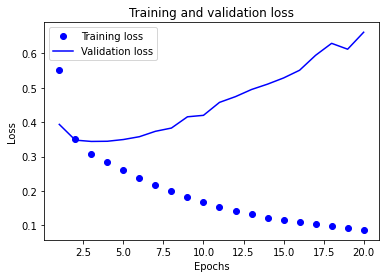

In [45]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9978 - accuracy: 0.6259
[0.9978067874908447, 0.6259332299232483]


# 회고
    1. 전처리와 ko.bin 임베딩을 에서 하루종일 헤맸지만.. 뭔가 된듯하니 만족한다
    2. 그래도 RNN과 패딩을 왜쓰는지는 확실히 이해가 되는 것 같다.
    3. 요즘 정말 많은 것들을 배우고 쓰고 듣고 하다보니 붕 뜬 느낌인데 설에 하나하나 정리
        해야겠다.